In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [ ]:
import torch
import pandas as pd
from tqdm.notebook import tqdm

In [ ]:

!pip install transformers


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 23.7 MB/s 
     |████████████████████████████████| 7.6 MB 70.7 MB/s 
     |████████████████████████████████| 182 kB 87.4 MB/s 


In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/Data/Final_dataset.csv')

In [ ]:
dataset.head()

,Unnamed: 0,Post,Suicidal_label,Sentiment_label
0,0,Ex Wife Threatening SuicideRecently I left my ...,0,0
1,1,Am I weird I don t get affected by compliments...,1,1
2,2,Finally is almost over So I can never hear ...,1,0
3,3,i need helpjust help me im crying so hard,0,0
4,4,I m so lostHello my name is Adam and I ve b...,0,0


In [ ]:
dataset = dataset.dropna()

In [ ]:
label_dict1 = {'suicide': 0, 'non-suicide': 1}

In [ ]:
label_dict2 = {'Negative': 0, 'Positive': 1, 'Neutral': 2}

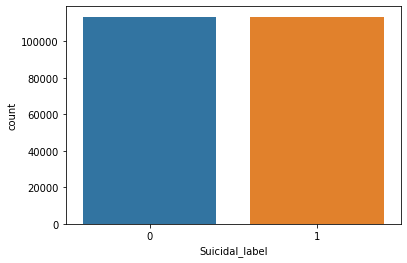

In [ ]:
sns.countplot(x='Suicidal_label',data=dataset)

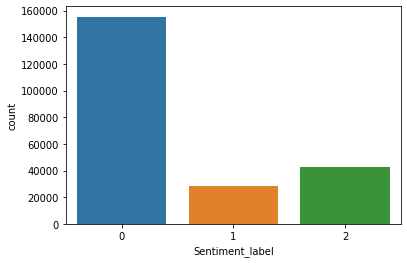

In [ ]:
sns.countplot(x='Sentiment_label',data=dataset)


In [ ]:
dataset.isnull().any()


Unnamed: 0         False
Post               False
Suicidal_label     False
Sentiment_label    False
dtype: bool

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y1_train, y1_val, y2_train, y2_val = train_test_split(dataset.index.values, 
                                                  dataset.Suicidal_label.values,
                                                  dataset.Sentiment_label.values, 
                                                  test_size=0.15, 
                                                  random_state=17, 
                                                  stratify=dataset.Suicidal_label.values)

In [ ]:
dataset['data_type'] = ['not_set']*dataset.shape[0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
dataset.loc[X_train, 'data_type'] = 'train'
dataset.loc[X_val, 'data_type'] = 'val'

##Loading Tokenizer and Encoding our Data for both tasks:

In [ ]:
from transformers import BertTokenizer
from torch.utils.data import TensorDataset

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
encoded_data_train = tokenizer.batch_encode_plus(
    dataset[dataset.data_type=='train'].text.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    dataset[dataset.data_type=='val'].text.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)



input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
label1_train = torch.tensor(dataset[dataset.data_type=='train'].Suicidal_label.values)
label2_train = torch.tensor(dataset[dataset.data_type=='train'].Sentiment_label.values)


input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
label1_val = torch.tensor(dataset[dataset.data_type=='val'].Suicidal_label.values)
label2_val = torch.tensor(dataset[dataset.data_type=='val'].Sentiment_label.values)



In [ ]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, label1_train,label2_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, label1_val,label2_val)

## Setting up BERT Pretrained Model



In [ ]:
from transformers import BertForSequenceClassification


In [ ]:
model1 = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels= 2,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model2 = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels= 3,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

## Creating Data Loaders



In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler


In [ ]:
batch_size = 32

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

## Setting Up Optimiser and Scheduler

---



In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

In [ ]:
optimizer1 = AdamW(model1.parameters(),
                  lr=1e-5, 
                  eps=1e-8)

optimizer2 = AdamW(model2.parameters(),
                  lr=1e-5, 
                  eps=1e-8)



/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
epochs = 1

scheduler1 = get_linear_schedule_with_warmup(optimizer1, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

scheduler2 = get_linear_schedule_with_warmup(optimizer2, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

## Defining our Performance Metrics for both tasks

In [ ]:
from sklearn.metrics import f1_score
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')
def accuracy_per_class(preds, labels):
  if len(np.unique(labels)) == 2:
    label_dict_inverse = {v: k for k, v in label_dict1.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')
  else:
    label_dict_inverse = {v: k for k, v in label_dict2.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

## Creating our Training Loop

In [ ]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model1.to(device)
model2.to(device)

print(device)

cuda


In [ ]:
def evaluate(dataloader_val):

    model1.eval()
    model2.eval()

    losses = []
    loss_val_total = 0
    predictions1, true_vals1 = [], []
    predictions2, true_vals2 = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs1 = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       
        inputs2 = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[3],
                 }    

        with torch.no_grad():        
            outputs1 = model1(**inputs1)
            outputs2 = model2(**inputs2)
            
        loss1 = outputs1[0]
        logits1 = outputs1[1]

        loss2 = outputs2[0]
        logits2 = outputs2[1]

        # Taking mean of losses
        loss = (loss1 + loss2)/2
        losses.append(loss.item())
        loss_val_total += loss.item()

        logits1 = logits1.detach().cpu().numpy()
        logits2 = logits2.detach().cpu().numpy()

        label_ids1 = inputs1['labels'].cpu().numpy()
        label_ids2 = inputs2['labels'].cpu().numpy()

        predictions1.append(logits1)
        true_vals1.append(label_ids1)

        predictions2.append(logits2)
        true_vals2.append(label_ids2)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions1 = np.concatenate(predictions1, axis=0)
    true_vals1 = np.concatenate(true_vals1, axis=0)

    predictions2 = np.concatenate(predictions2, axis=0)
    true_vals2 = np.concatenate(true_vals2, axis=0)
            
    return losses, loss_val_avg, predictions1, true_vals1, predictions2, true_vals2

In [ ]:
for epoch in tqdm(range(1, epochs+1)):
    
    model1.train()
    model2.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model1.zero_grad()
        model2.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        # print(batch)
        
        inputs1 = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       
        inputs2 = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[3],
                 }    

        outputs1 = model1(**inputs1)
        outputs2 = model2(**inputs2)
        
        loss1 = outputs1[0]
        loss2 = outputs2[0]
        loss = (loss1+loss2)/2
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model1.parameters(), 1.0)
        torch.nn.utils.clip_grad_norm_(model2.parameters(), 1.0)

        optimizer1.step()
        scheduler1.step()

        optimizer2.step()
        scheduler2.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model1.state_dict(), f'/content/drive/MyDrive/Data/multi_task1_epoch{epoch}.model')
    torch.save(model2.state_dict(), f'/content/drive/MyDrive/Data/multi_task2_epoch{epoch}.model')

        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)             
    tqdm.write(f'Training loss: {loss_train_avg}')

In [ ]:
losses, val_loss, predictions1, true_vals1, predictions2, true_vals2= evaluate(dataloader_validation)
val_f1_1 = f1_score_func(predictions1, true_vals1)
val_f1_2 = f1_score_func(predictions2, true_vals2)
print(f'Validation loss: {val_loss}')
print(f'F1 Score Suicidal Prediction (Weighted): {val_f1_1}')
print(f'F1 Score Sentiment Prediction(Weighted): {val_f1_2}')

Validation loss: 0.18440408299731417
F1 Score Suicidal Prediction (Weighted): 0.9626764279087764
F1 Score Sentiment Prediction(Weighted): 0.8882141907136949


In [ ]:
accuracy_per_class(predictions2, true_vals2)

Class: Negative
Accuracy: 20697/21685

Class: Positive
Accuracy: 3446/4231

Class: Neutral
Accuracy: 4155/5887



In [ ]:
accuracy_per_class(predictions1, true_vals1)

Class: suicide
Accuracy: 15290/15902

Class: non-suicide
Accuracy: 15326/15901



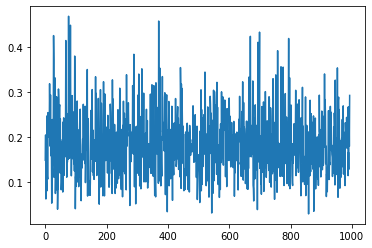

In [ ]:
from matplotlib import pyplot as plt
plt.plot(losses)

## Test Dataset

In [ ]:
testset = pd.read_csv('/content/drive/MyDrive/Data/testset.csv')
testset.head()


,Unnamed: 0,Post,Suicidal_label,Sentiment_label
0,0,I ve pushed everyone awayI moved away from my ...,0,0
1,1,Gonna go cook some ramen boys And I don t mean...,1,2
2,2,smilemy father today smiled at me but it looke...,0,0
3,3,I keep being told to be careful by people th...,0,0
4,4,Yoo anyone down to give me some advice or just...,1,0


In [ ]:
testset = testset.dropna()

Tokenizing data

In [ ]:
encoded_data_test = tokenizer.batch_encode_plus(
    testset.Post.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)


input_ids_test = encoded_data_test['input_ids']
attention_masks_test = encoded_data_test['attention_mask']
label1_test = torch.tensor(testset.Suicidal_label.values)
label2_test = torch.tensor(testset.Sentiment_label.values)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
dataset_test = TensorDataset(input_ids_test, attention_masks_test,label1_test,label2_test)

## Creating Data Loaders



In [ ]:
batch_size = 32

dataloader_test = DataLoader(dataset_test, 
                              sampler=RandomSampler(dataset_test), 
                              batch_size=batch_size)

In [ ]:
losses, test_loss, predictions1, true_vals1, predictions2, true_vals2= evaluate(dataloader_test)


In [ ]:
test_f1_1 = f1_score_func(predictions1, true_vals1)
test_f1_2 = f1_score_func(predictions2, true_vals2)
print(f'Test loss: {test_loss}')
print(f'F1 Score Suicidal Prediction (Weighted): {test_f1_1}')
print(f'F1 Score Sentiment Prediction(Weighted): {test_f1_2}')

Test loss: 0.15577869528904556
F1 Score Suicidal Prediction (Weighted): 0.9708111967065645
F1 Score Sentiment Prediction(Weighted): 0.9001942215407783


In [ ]:
accuracy_per_class(predictions2, true_vals2)

Class: Negative
Accuracy: 4204/4352

Class: Positive
Accuracy: 647/770

Class: Neutral
Accuracy: 898/1250



In [ ]:
accuracy_per_class(predictions1, true_vals1)

Class: non-suicide
Accuracy: 3154/3255

Class: suicide
Accuracy: 3032/3117



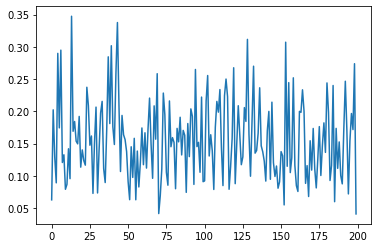

In [ ]:
from matplotlib import pyplot as plt
plt.plot(losses)